# Example: Two-Body Problem in the Co-Moving Frame

Recall the equations of motion for the two-body problem in a reference frame attached to $m_1$:

$$\begin{aligned}\vector{r} &= x\uvec{\imath} + y\uvec{\jmath} + z\uvec{k}\\\vector{v} &= \dot{x}\uvec{\imath} + \dot{y}\uvec{\jmath} + \dot{z}\uvec{k}\\\vector{a} &= \ddot{x}\uvec{\imath} + \ddot{y}\uvec{\jmath} + \ddot{z}\uvec{k}\\\end{aligned}$$

where

$$\begin{aligned}\ddot{x} &= -\frac{\mu}{r^3}x & \ddot{y} &= -\frac{\mu}{r^3}y & \ddot{z} &= -\frac{\mu}{r^3}z\end{aligned}$$

In this Notebook, we will solve the two-body problem for relative motion and plot the results.

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

First, we set up the initial values and constants. Recalling the definition of $\mu$:

$$\mu = G\left(m_1 + m_2\right)$$

In the function we will write, the state vector will be called $Y$, so its initial value is $Y_0$. Remember that the state vector includes 6 components, 3 positions and 3 velocities. These all need to be stored in one array.

In [2]:
G = 6.67430E-20  # km**3/(kg * s**2)
m_1 = 5.974E24  # kg
m_2 = 1000  # kg
mu = G * (m_1 + m_2)
R_E = 6378.12  # km
r_0 = np.array((8000, 0, 6000))  # km
v_0 = np.array((0, 7, 0))  # km/s
Y_0 = np.hstack((r_0, v_0))

Then, we need to define the function that describes the motion of our system. This function needs to compute the left hand side of the equation above ($\dot{\vector{Y}}$) and return it to the solver, so that the solver can calculate the value of the state vector at time $t + \Delta t$.

The function takes the time $t$ and current value of the state vector $y$ as inputs. Because of the way that we constructed the initial values, the first 3 values of the state vector are the coordinates of $m_1$, the next 3 values are the coordinates of $m_2$, the next 3 values are the velocity components of $m_1$, and the last three values are the velocity components of $m_2$. However, if you construct your initial state vector in a different order, make sure you match that order in your function. It doesn't matter what order you choose, as long as you're consistent.

Inside the function, we use the values in the state vector to fill the `Ydot` vector. Then, we return `Ydot` back to the solver.

In [4]:
def relative_motion(t, Y):
    """Calculate the motion of a two-body system relative to $m_1$.
    
    The state vector ``Y`` should be in the order:
    
    1. Relative coordinates of $m_2$ relative to $m_1$
    2. Velocity components of $m_2$ relative to $m_1$
    """
    # Get the three position components
    x, y, z = Y[:3]
    
    # Create the derivative vector and copy the velocities into it
    Ydot = np.zeros(len(Y))
    Ydot[:3] = Y[3:]
    
    # Calculate the accelerations
    r = np.sqrt(x**2 + y**2 + z**2)
    temp = -mu / r**3
    Ydot[3:] = temp * Y[:3]

    return Ydot

With the function defined, we can call `solve_ivp()`. We need to tell it the function it should solve, the beginning and end times, the initial state vector, and then some information to help control the output.

Once the solver finishes, the solution is stored in `sol.y`. Each column of `sol.y` corresponds to a single timestep and each row corresponds to one of the state variables. It is more convenient to work with the transpose of this array, so we do that and define `y`. Then we extract the position and velocity of each mass as a function of time, and compute the barycenter (the center of gravity of the system).

In [6]:
t_0 = 0  # seconds
t_f = 14_400  # seconds
t_points = np.linspace(t_0, t_f, 10000)
sol = solve_ivp(relative_motion, [t_0, t_f], Y_0, t_eval=t_points)

Y = sol.y.T
r = Y[:, :3]  # km
v = Y[:, 3:]  # km/s

In [7]:
r_mag = np.sqrt(r[:, 0]**2 + r[:, 1]**2 + r[:, 2]**2)
altitude = r_mag - R_E
speed = np.sqrt(v[:, 0]**2 + v[:, 1]**2 + v[:, 2]**2)

min_altitude = np.min(altitude)
i_min = np.argmin(altitude)
max_altitude = np.max(altitude)
i_max = np.argmax(altitude)
speed_at_min_alt = speed[i_min]
speed_at_max_alt = speed[i_max]
print(f"The minimum altitude during the orbit is: {min_altitude:.2F} km")
print(f"The velocity at the minimum altitude is: {speed_at_min_alt:.2F} km/s")
print(f"The maximum altitude during the orbit is: {max_altitude:.2F} km")
print(f"The velocity at the maximum altitude is: {speed_at_max_alt:.4F} km/s")

The minimum altitude during the orbit is: 3621.88 km
The velocity at the minimum altitude is: 7.00 km/s
The maximum altitude during the orbit is: 9419.16 km
The velocity at the maximum altitude is: 4.4389 km/s


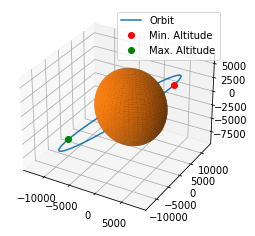

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(r[:, 0], r[:, 1], r[:, 2], label="Orbit");

p = np.linspace(0, np.pi, 100)
t = np.linspace(0, 2*np.pi, 100)
P, T = np.meshgrid(p, t)

X = R_E * np.cos(T) * np.sin(P)
Y = R_E * np.sin(T) * np.sin(P)
Z = R_E * np.cos(P)

ax.plot_surface(X, Y, Z);
ax.plot(r[i_min, 0], r[i_min, 1], r[i_min, 2], 'ro', label="Min. Altitude")
ax.plot(r[i_max, 0], r[i_max, 1], r[i_max, 2], 'go', label="Max. Altitude")
ax.legend();